# Neural Network

Let's try to "learn" the "exclusive or" function. Unlike "and" or "or", it cannot be learned by a single neuron/perceptron, because it is not linearly seperable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

For two inputs, xor is true when one of them is true, and false otherwise.

In [2]:
training_inputs = np.array([
    [1, 1],
    [1, 0],
    [0, 1],
    [0, 0]
])

training_labels = np.array([0, 1, 1, 0])

Massage our training data into the shape we need. This is because `np.dot` needs things to be aligned correctly (in terms of matrix/vector dimensions).

Wouldn't need this at all if we were looping through each node of each layer one at a time, because we would just be doing multiplication and not using the dot product.

In [3]:
training_inputs = training_inputs.T
training_labels = training_labels.reshape(1, -1)

For this example we'll be using the [Relu](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) activation function for all layers but the last, for which we'll be using [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) (so that its values fall between 0 and 1).

For back propagation we'll also need the derivatives of each.

In [4]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_derivative(Z):
    # Note that the derivative of sigmoid is defined in terms of sigmoid itself. This means that we could
    # cache off values when we do forward propagation, and re-use them here. Most deep learning applications
    # seem to do that. Here I've chosen to keep the overall model simpler, at the expense of computational
    # efficiency.
    return sigmoid(Z) * (1 - sigmoid(Z))

def relu_derivative(Z):
    dZ = np.array(Z, copy=True)
    
    # When Z <= 0, dZ is 0. 
    dZ[Z <= 0] = 0
    
    # When Z > 0, dZ is 1.
    dZ[Z > 0] = 1
    
    return dZ

Our main "model". This is the highest-level function here, and will handle:
- Initializing our weights and biases
- Running forward propagation
- Running backward propagation
- Returning the final weights and biases

In [5]:
def model(inputs, labels, learning_rate, iterations):
    # 2 nodes in the input layer, 3 in the hidden layer, and 1 output.
    parameters = init_params(2, 3, 1)
    costs = []
    
    for i in range(iterations):
        prediction = propagate_forward(inputs, parameters)
        costs.append(compute_cost(prediction, labels))
        gradients = propagate_backward(prediction, labels)
        parameters = update_parameters(parameters, gradients, learning_rate)
        
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.show()
    
    return parameters

Initialize our weights and biases. There are a couple interesting things to note here.

First, the input layer doesn't have weights or biases. So if we have a 3-layer network (input, one hidden, and the output), we end up with only two sets of weights/biases.

Second, the number of weights for a layer is the connections between the _previous_ layer and the _current_ one. So if there are 2 inputs and 3 hidden nodes, we have 2 * 3 - or 6 - connections and therefore weights between them.

In [6]:
def init_params(*layer_dimensions):
    num_layers = len(layer_dimensions)
    weights = []
    biases = []
    
    # As discussed above, we end up with `num_layers - 1` sets of weights and biases.
    for l in range(1, num_layers):
        # The number of weights for this layer is the product of the current layer's node count and the previous's.
        w = np.random.randn(layer_dimensions[l], layer_dimensions[l - 1])
        weights.append(w)
        
        # The number of biases for this layer is just the number of nodes.
        b = np.zeros((layer_dimensions[l], 1))
        biases.append(b)
        
    return {
        'weights': weights,
        'biases': biases
    }

Forward propagation.

Note that we use Relu as the activation function for all layers except the last one, which we use Sigmoid for.

Another interesting thing is that conceptually to calculate the value for a node, we take all of its connections to the previous layer and add up the value of the connected node multiplied by the weight of the connection. While we could easily do that in straight Python, here we're doing all nodes for a given layer at the same time (in parallel) using Numpy.

That's why you see a dot product here, instead of looping and multiplying and adding.

In [7]:
def propagate_forward(X, parameters):
    num_steps = len(parameters['weights'])
    # The initial "activations" are just the inputs.
    activations_current = X
    
    # Skip the last (output) layer, which we'll handle separately.
    for i in range(num_steps - 1):
        activations_previous = activations_current
        W = parameters['weights'][i]
        b = parameters['biases'][i]
        activations_current = linear_activation_forward(activations_previous, W, b, relu)
        
    # For the last layer, use the Sigmoid activation. This is our prediction.
    W = parameters['weights'][num_steps - 1]
    b = parameters['biases'][num_steps - 1]
    prediction = linear_activation_forward(activations_current, W, b, sigmoid)
    
    return prediction

def linear_activation_forward(activations_previous, weights, bias, activation):
    # Using the dot product of the weights matrix and the activations vector. This is basically an
    # efficient way of adding together the inputs multiplied by each corresponding weight, for all
    # nodes in the layer.
    Z = np.dot(weights, activations_previous) + bias
    A = activation(Z)
    return A

Compute the cost. This is a version of [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), and is used mainly to graph our progress.

In [8]:
def compute_cost(prediction, labels):
    num_examples = labels.shape[1]
    
    cost = -(1 / num_examples) * np.sum(np.multiply(labels, np.log(prediction)) + np.multiply(1 - labels, np.log(1 - prediction)))
    return np.squeeze(cost)

Backward propagation.

In [9]:
def propagate_backward(prediction, labels):
    return None

Update parameters.

In [10]:
def update_parameters(parameters, gradients, learning_rate):
    return parameters

We're finally ready to train our model!

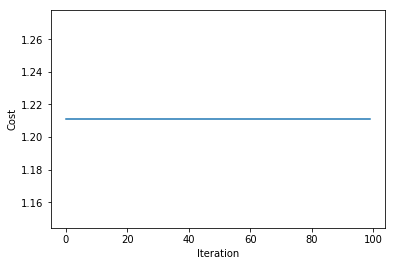

In [11]:
parameters = model(training_inputs, training_labels, 0.25, 100)

And last, let's make some predictions!

In [12]:
def predict(inputs, parameters):
    num_examples = inputs.shape[1]
    num_layers = len(parameters)
    predictions = np.zeros(num_examples)
    
    # Forward propagation
    probabilities = propagate_forward(inputs, parameters)
    
    # Convert probabilities to 0/1
    for i in range(0, probabilities.shape[1]):
        if probabilities[0, i] > 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0
            
    return predictions

In [13]:
predict_on = np.array([
    np.array([1, 0]), # True and False
    np.array([0, 1]), # False and True
    np.array([1, 1]), # True and True
    np.array([0, 0]), # False and False
    np.array([1, 1]), # True and True
    np.array([0, 1]), # False and True
    np.array([0, 0]), # False and False
    np.array([1, 0])  # True and False
])

predictions = predict(predict_on.T, parameters)

In [14]:
import pandas as pd
from IPython.display import HTML, display

dataframe = pd.DataFrame({
    'Input A': predict_on.T[0],
    'Input B': predict_on.T[1],
    'Predicted XOR': predictions,
    'Actual XOR': [1, 1, 0, 0, 0, 1, 0, 1]
})

display(HTML(dataframe.to_html()))

,Input A,Input B,Predicted XOR,Actual XOR
0,1,0,0.0,1
1,0,1,0.0,1
2,1,1,0.0,0
3,0,0,0.0,0
4,1,1,0.0,0
5,0,1,0.0,1
6,0,0,0.0,0
7,1,0,0.0,1
